### Management and Analyisis of Physics Datasets mod. B
# Distributed Algorithms
### Group 4 (🤮) - Bacilieri, Barbiero, Bordin, Pitteri

## 0 - Abstract
A number of common algorithms used in Data Science and Machine Learning are not by default designed to take advantage of the parallelization offered by distributed systems. In this project we'll implement several K-means algorithm specifically design to take advantage of distributed systems using the PySpark API of Spark and the Cloud Veneto computing resources.

Our cluster was composed by one master node and two worker nodes providing:
- 4 physical cores, one thread each
- 8 (?) GB of RAM
each

## 1 - Spark Session

In [1]:
from sklearn.datasets import fetch_kddcup99

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, array, min as smin, lit, count, isnan, when, sum as ssum
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("k-meaner") \
    .config("spark.executor.memory", "1024m") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

#clear old data if rerunning
spark.catalog.clearCache() 
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/07/12 15:52:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 2 - Dataset
The dataset we decided to benchmark our algorithms on is the `KDDCup99` dataset.
While we're not interested in the specific topics covered by the dataset it is still important to describe its key features

In [3]:
kdd = spark.createDataFrame(fetch_kddcup99(as_frame=True)["frame"])

kdd.printSchema()

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

As we can see `kdd` is dataframe where the first elements are the features of the data points, while the last element is filled with the corresponding labels – i.e., the attack types.

### Pre Processing

- Remove the first three “categorical” columns, and keep only the numerical ones. 
- Rescale everything in [0-1] range
- In doing so, ignore the two columns that happen to be all zeros.

In [6]:
kdd = kdd.drop("protocol_type")
kdd = kdd.drop("service") 
kdd = kdd.drop("flag")

kdd.createOrReplaceTempView("kdd_table")

for c in kdd.columns:
    try:
        limits = spark.sql("SELECT min(" + c + "), max(" + c + ") FROM kdd_table").collect()
        mn, mx = limits[0][0], limits[0][1]
        
        if mn==mx: #ignore columns with no variations
            continue
        
        
        kdd = kdd.withColumn(c, (col(c)-mn)/(mx-mn) )
        
        #print(limits[0][0], limits[0][1])
    except Exception as e:
        print(e)

kdd = kdd.persist()

unsupported operand type(s) for -: 'bytearray' and 'bytearray'


In [7]:
kdd.printSchema()

root
 |-- duration: double (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: double (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror

### Attack types distribution

In [8]:
res = spark.sql("SELECT labels, count(1) FROM kdd_table GROUP BY labels").collect()

attacks = np.array([r[0] for r in res])
counts = np.array([r[1] for r in res])
attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

ypos = np.arange(len(attacks))

/tmp/ipykernel_39/1192132600.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  attacks = np.array([r[0] for r in res])


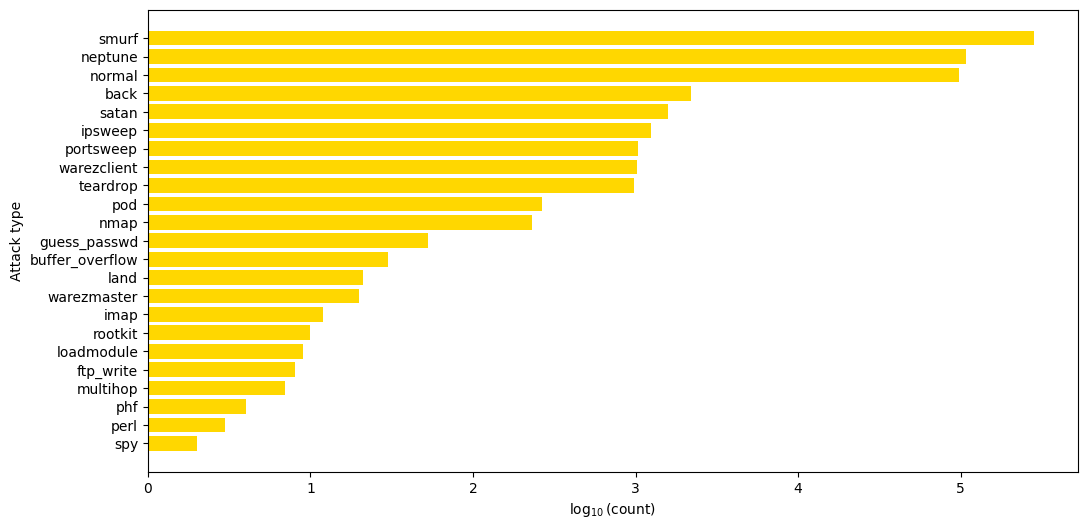

In [9]:
plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

Attack types vary significantly in frequency so we will have to keep this in mind during later clustering

## 3 - Lloyd's Algorithm
The K means algorithm is widely used in Machine Learing clustering applications due to its simple implementation which roughly follows these steps.

- Start from a set of points as centers for the clusters
- Classify data points based on closest cluster center
- Set new cluster center as the mean of clustered points and repeat until convergence or max iterations

This algorithms is known as Lloyd's algorithm

### Prep work

In [10]:
def dist(x,y):
    try:
        #return (((np.array(x)-y)**2).sum())**0.5
        return np.linalg.norm(np.array(x)-np.array(y))
    except Exception as e:
        #print(e)
        return ncols

def argcomp(comp,func, arr, *params):
    res = [func(arr[i], *params) for i in range(len(arr))]
    #print(res)
    return res.index(comp(res))

index_udf = udf(lambda row:attacks.tolist().index(row))

Some of the columns will contain meta information about the data rows. As such, we must ignore them when calculating the distances from the centroids.

In [11]:
ignored_cols = ["labels", "centr", "cost", "p", "w"]

kdd = kdd.withColumn("labels", index_udf(col("labels")).cast("int"))
kdd = kdd.withColumn("centr", lit(-1))
kdd = kdd.withColumn("cost", lit(0.))
kdd = kdd.withColumn("p", lit(0.))

ncols = len([c for c in kdd.columns if c not in ignored_cols])

kdd.printSchema()

root
 |-- duration: double (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: double (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror

### Lloyd

In [12]:
def kmeans(data, centers, max_iter=100, weighted=False, local_centr=False, return_cost=False):
    count = 0
    
    
    cols = data.columns
    
    cost = [float("inf")] # initialize to inf so the first iteration will surely not interrupt due to convergence
    
    while count<=max_iter:
        if local_centr:
            cc = centers
            local_centr = False
        else:
            cc = centers.collect()
        #print(cc)
        
        ## set center affiliation
        argmindist_udf = udf(lambda row: argcomp(min,dist,cc,row), IntegerType())
        data = data.withColumn("centr", argmindist_udf(array([c for c in cols if c not in ignored_cols])))
        
        ## calculate new centers
        if not weighted:
            centers = data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols])
        else:
            centers = data.rdd.map(
                lambda x: (x["centr"],(np.array([x[c] for c in cols if c not in ignored_cols]),x["w"]))
            ).reduceByKey(
                lambda x,y: ((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]), x[1]+y[1])
            ).map(lambda x: x[1][0])
        
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in cc])))
        
        if not weighted:
            data = data.withColumn("cost", get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))
        else:
            data = data.withColumn("cost", col("w")*get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))
        
        newcost = data.select("cost").groupBy().sum().collect()[0][0]
        
        count+=1
        if newcost/cost[-1]>0.99:
            break
        
        cost.append(newcost)
            
    if return_cost:
        return data, centers, cost[1:]
    else:
        return data, centers

## 4 - Centroids initialization
In order to optimize performance of the Lloyd's algorithm proper centroids initialization is paramount. Here we'll propose three initialization methods

### JSI (Just Stupid Initialization)
The most general way to decide the first centroids is to initialize them randomly all at once.

In [13]:
def uniform_init(k, mn=0, mx=1):
    return pd.DataFrame(np.random.random(size=(k, ncols))*(mx-mn) - mn)

This simple algorithm is, however, often times not the best choice for performance since clusters can be chosen in sub-optimal configurations

### Kmeans++
On the other end of the spectrum we have `Kmeans++`. 
This algorithms initializes centroids sequentially one by one with the following logic
- assign the first center randomly
- each next centroid is assigned with probability proportional to the distance from each other centroid

This assures centroids evenly spaced across the feature space but has the drawback of being inherently sequential in nature and thus cannot benefit from a parallel cluster

In [14]:
def kplus_init(data, n_clusters):
    c = np.empty((n_clusters, data.shape[1]))
    c[0] = data[np.random.choice(data.shape[0])]

    for i in range(1, n_clusters):
        distances = np.sum((data[:, np.newaxis] - c[:i])**2, axis=-1)
        closest = np.argmin(distances, axis=-1)
        
        distances = distances[np.arange(len(distances)), closest]
        
        distances = distances / np.sum(distances)
        c_idx = choice(np.arange(len(distances)), p=distances)
        c[i] = data[c_idx]

    return c

### Kmeans||
The middle ground between the two initialization methods is to be found in `Kmeans||`. Centroids here are initialized in groups (thus parallelizable)

In [15]:
def kmeans_parallel(data, k, l):
    centr = data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(True,2)
    #define get_cost using udf on min(dist(row,centr[i]))
    get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
    
    data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
    
    cost = data.select("cost").groupBy().sum().collect()[0][0]
    
    for i in range(int(np.log(cost))):
        #re-define get_cost using udf on min(dist(row,centr[i]))
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
        data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
        cost = data.select("cost").groupBy().sum().collect()[0][0]
        
        data = data.withColumn("p", udf(lambda row: np.random.random())(col("cost")))
        
        centr.extend( data.where( data["cost"] * l > cost * data["p"]).select(array([c for c in data.columns if c not in ignored_cols])).collect() )
    
    ## search for possible identical centroids ? 
    #should be taken care of thanks to the weighting, methinks
    
    if len(centr) > k: 
        #get weights
        data, _ = kmeans(data, centr, max_iter=0, local_centr=True)
        counts = data.groupBy("centr").count().collect()
        counts = sorted(counts)
        
        #parallelize the centroid dataset
        cdata = spark.createDataFrame(pd.DataFrame([[*centr[i][0], counts[i][1]] for i in range(len(centr))], columns=(0,1,"w")))
        cdata = cdata.withColumn("w", col("w").cast("double"))
        
        ## basically kmeans++ on the centroids as init for the weighted k-means
        c = [centr[np.random.randint(len(centr))]]
        for i in range(k-1):
            costs = [min([dist(centr[j], c[k])**2 for k in range(len(c))]) for j in range(len(centr))]
            p = np.cumsum(costs)
            p/= p[-1]
            c.append(centr[(p>np.random.random()).tolist().index(True)])
        
        
        _, centr = kmeans(cdata, c, local_centr=True, weighted=True)
        centr = centr.collect()
    return centr

## 5 - Mini Batch Kmeans
Another way to exploit parallel architectures for a Kmeans clustering task is through the usage of mini batch Kmeans (MBK).
Unlike the previous methods, MBK performs iterative clusterings for small batches of the dataset and updates centroids positions based on a learning rate. This is generally slower compared to previous methods but its simple and flexible implementation along with the excellent scaling w.r.t. the size of the dataset (the algo never looks at the whole dataset) makes it a viable alternative

In [16]:
def mini_b(data,batch_size,n_cent,l_rate=0.05,max_it=None):
    if max_it is None:
        max_it = int(2/batch_size) #standard (is it?) amount of iterations
    
    #first centroids initialization
    initialCentroids = data.sample(batch_size).limit(n_cent).select(*[col(c) for c in data.columns if c not in ignored_cols])
    initialCentroids = np.array(initialCentroids.collect())
    
    miniBatch = data.sample(batch_size)
    _, _, cost = kmeans(miniBatch,initialCentroids, local_centr=True, max_iter=0, return_cost=True)
    
    #centroids update
    for _ in range(max_it):
        miniBatch = data.sample(batch_size)
        
        _,newCentroids, newcost = kmeans(miniBatch,initialCentroids, local_centr=True, max_iter=5, return_cost=True)
        
        newCentroids = np.array(newCentroids.collect())
        
        #sort centroids to minimize reciprocal distance by finding the optimal permutation on newCentroids
        
        distances = np.linalg.norm(initialCentroids[:, np.newaxis] - newCentroids, axis=2)
        permutation = np.argmin(np.sum(distances, axis=0))
        newCentroids = newCentroids[permutation]
        
        initialCentroids = (1-l_rate) * initialCentroids + newCentroids * l_rate
        
        if newcost[-1]/cost[-1]>0.99:
            break
        else:
            cost=newcost

    return initialCentroids

The middle permutation was needed since there's no guarantee that the returning list of centroids will be in the same order as the original one

## 6 - Tests

In [17]:
newcenters = mini_b(kdd,0.2,len(attacks),0.05,10)
mini_data,_=kmeans(kdd,newcenters, local_centr=True)

In [ ]:
unif_data, _ = kmeans(kdd, uniform_init(len(attacks)), local_centr=True)

In [18]:
c = kmeans_parallel(kdd, len(attacks), 3.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids
per_data, _ = kmeans(kdd, c, local_centr=True)

In [19]:
u_data = unif_data.select("labels", "centr").groupBy("labels", "centr").count().collect()
p_data = per_data.select("labels", "centr").groupBy("labels", "centr").count().collect()
m_data = mini_data.select("labels", "centr").groupBy("labels", "centr").count().collect()

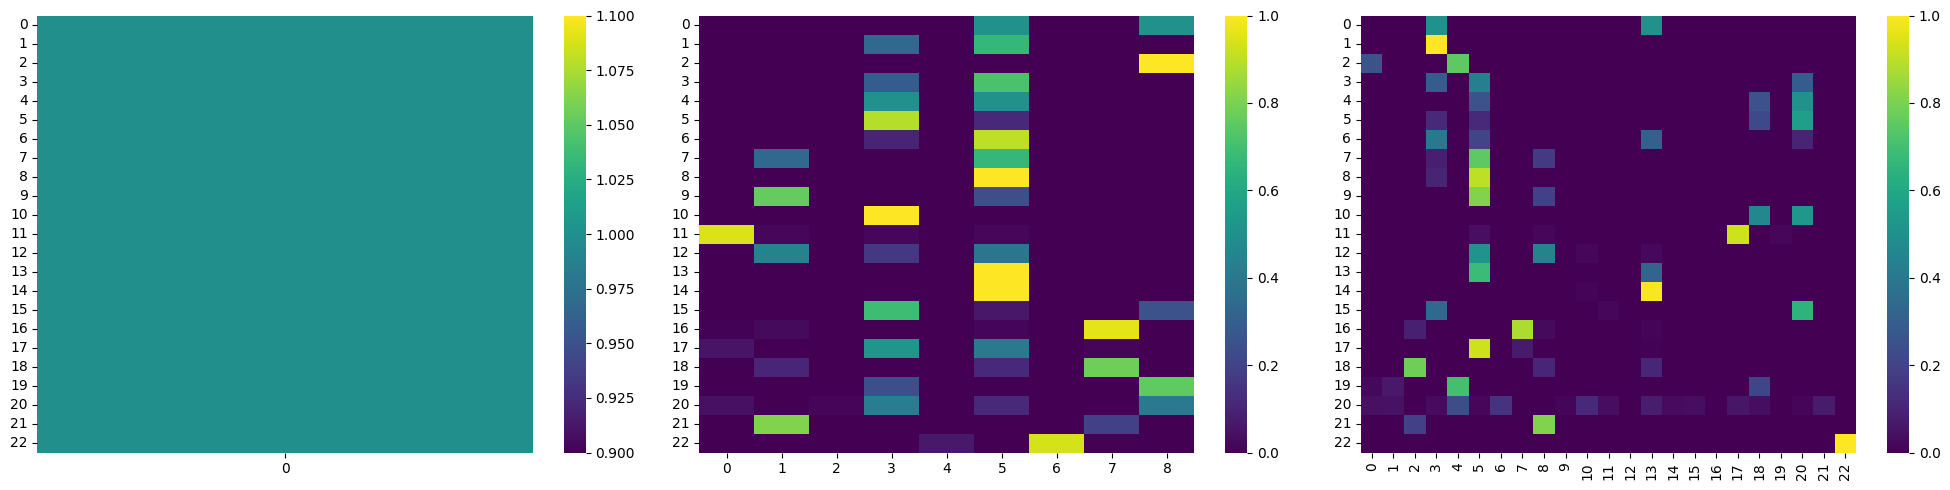

In [20]:
u_mat = np.zeros(shape= ((np.max(u_data, axis=0)+1)[0:2]).tolist())
p_mat = np.zeros(shape= ((np.max(p_data, axis=0)+1)[0:2]).tolist())
m_mat = np.zeros(shape= ((np.max(m_data, axis=0)+1)[0:2]).tolist())

for d in u_data:
    u_mat[d[0]][d[1]]=d[2]

for d in p_data:
    p_mat[d[0]][d[1]]=d[2]

for d in m_data:
    m_mat[d[0]][d[1]]=d[2]


for i in range(len(u_mat)):
    u_mat[i]/= sum(u_mat[i])

for i in range(len(p_mat)):
    p_mat[i]/= sum(p_mat[i])

for i in range(len(m_mat)):
    m_mat[i]/= sum(m_mat[i])
    
fig, ax=plt.subplots(ncols=3, figsize=(20,5))
sns.heatmap(u_mat, ax=ax[0], cmap="viridis")
sns.heatmap(p_mat, ax=ax[1], cmap="viridis")
sns.heatmap(m_mat, ax=ax[2], cmap="viridis")
fig.tight_layout()

## 7 - Close session

In [21]:
sc.stop()
spark.stop()